In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from matplotlib import dates

from sklearn.linear_model import LinearRegression

%matplotlib inline 

In [2]:
df=pd.read_csv('Booking Exercise.csv')


In [3]:
df.head()

,DATE,DOW,DEMAND,TUESDAY.BOOK,PICKUP.RATIO,DOW.INDEX
0,2010-05-23,1,1470.0,1512,0.972222,0.864773
1,2010-05-24,2,870.0,864,1.006944,0.910585
2,2010-05-25,3,986.0,827,1.192261,0.972883
3,2010-05-26,4,1247.0,952,1.309874,1.012525
4,2010-05-27,5,1109.0,740,1.498649,1.067881


In [4]:
df.columns=[i.lower().replace('.','_') for i in df.columns]

df.set_index(pd.to_datetime(df.date),inplace=True)
df.drop(['date'],axis=1,inplace=True)
df.head()#Daily data, we do not need to resample the data to 

,dow,demand,tuesday_book,pickup_ratio,dow_index
date,,,,,
2010-05-23,1,1470.0,1512,0.972222,0.864773
2010-05-24,2,870.0,864,1.006944,0.910585
2010-05-25,3,986.0,827,1.192261,0.972883
2010-05-26,4,1247.0,952,1.309874,1.012525
2010-05-27,5,1109.0,740,1.498649,1.067881


In [5]:
df.describe()

,dow,demand,tuesday_book,pickup_ratio,dow_index
count,94.000000,87.000000,94.000000,87.000000,94.000000
mean,3.936170,1503.724138,1424.521277,1.100441,0.997322
std,2.015043,312.914755,408.003208,0.161697,0.084627
min,1.000000,722.000000,599.000000,0.846117,0.864773
25%,2.000000,1262.000000,1030.750000,0.962249,0.910585
50%,4.000000,1600.000000,1485.000000,1.076139,1.012525
75%,6.000000,1773.500000,1749.500000,1.198544,1.067881
max,7.000000,1924.000000,2105.000000,1.551300,1.122727


### Checking for stationarity is njot required for adduitional models like ETS and decomposition but is strictly required for ARIMA based model in order to estimate/forecast future values; as we make use of mean of y in predciting future values of y in ARIMA model

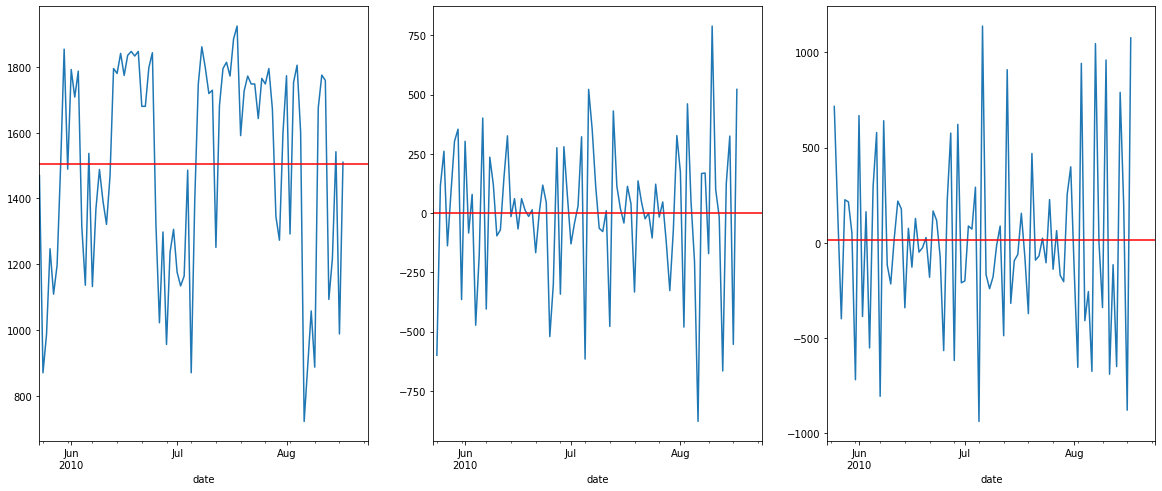

In [6]:
f,ax=plt.subplots(1,3,figsize=(20,8))
df['demand'].plot(ax=ax[0])
ax[0].axhline(df['demand'].mean(),color='r')
df['demand'].diff().plot(ax=ax[1])
ax[1].axhline(df['demand'].diff().mean(),color='r')
df['demand'].diff().diff().plot(ax=ax[2])
ax[2].axhline(df['demand'].diff().diff().mean(),color='r')

Primarily the time series data can be assumed to be a combination of some trend ,seasonality and some residual terms


There can be at times presence of some non-periodic events, that can be detected and embedded in the additive models


Removing the seasonal part helps to understand the holistic growing behaviour of the variable.
Seasonality is periodic and many of time syymetric in nature.
The average value of the seasonality over the course of period will drop to zero.
(Visualize a sine curve)

So I tried first to remove the seasonal part by detecting periodicity at different periods.
Following I plotted and assessed the trend. 

<!-- I tried to detect the thrend using simple assumptions of naive, moving average and at last a linear model -->



Sine curve attains zero average in a (i to 2pi +i) region for all values of i 

Therefore we can use rolling curve to generate average at each ith incident 
If we know the right period(lets assume yearly period)
 then avg(Yseasonality) =0 between i to year+1
 Sine curve logic

Thus rolling mean can help us remove effect of seasonality

In [7]:
df.index.min(),df.index.max(),df.index.to_series().diff()[2]#Therefore we have 3 months data smapled on daily basis

df=df[['demand']]

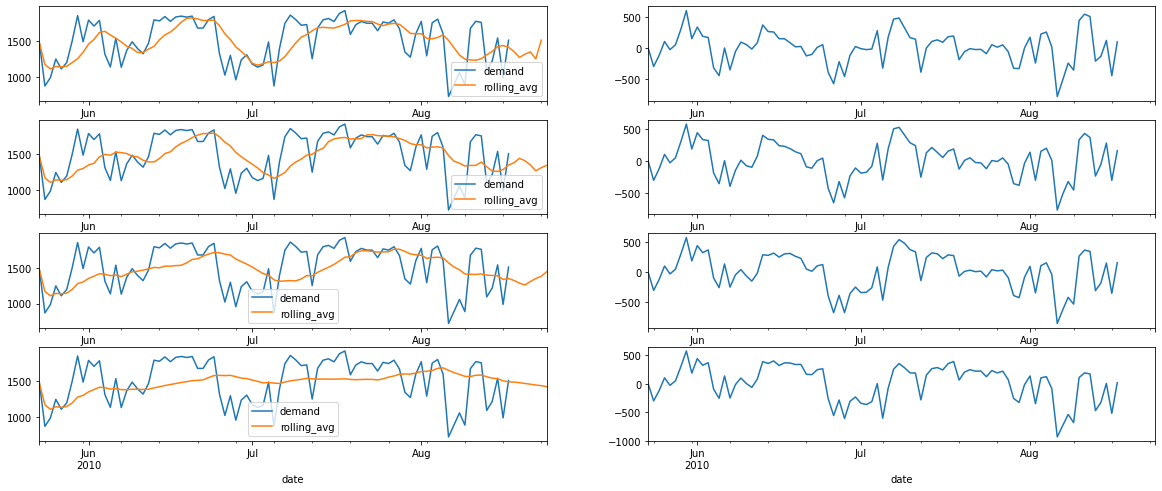

In [8]:
#Seasonality can be 7 days, 10 days,15days or 30 days
f,ax=plt.subplots(4,2,figsize=(20,8))
for i,d in enumerate([7,10,15,30]):
  temp=df.copy()
  temp=temp.assign(rolling_avg=temp.rolling(d,min_periods=1).mean())
  temp.plot(ax=ax[i,0])
  (temp['demand']-temp['rolling_avg']).plot(ax=ax[i,1])
  

# df.rolling(7).mean().plot()

No precise trend can be observed in this data 

I tried to generalise a simple linear model to detrend the data and visualise some seasonality pattern along with residual if present 

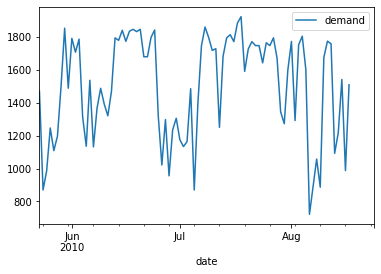

In [9]:
df.plot()

the slope of the genaralized trend is [0.37768827]


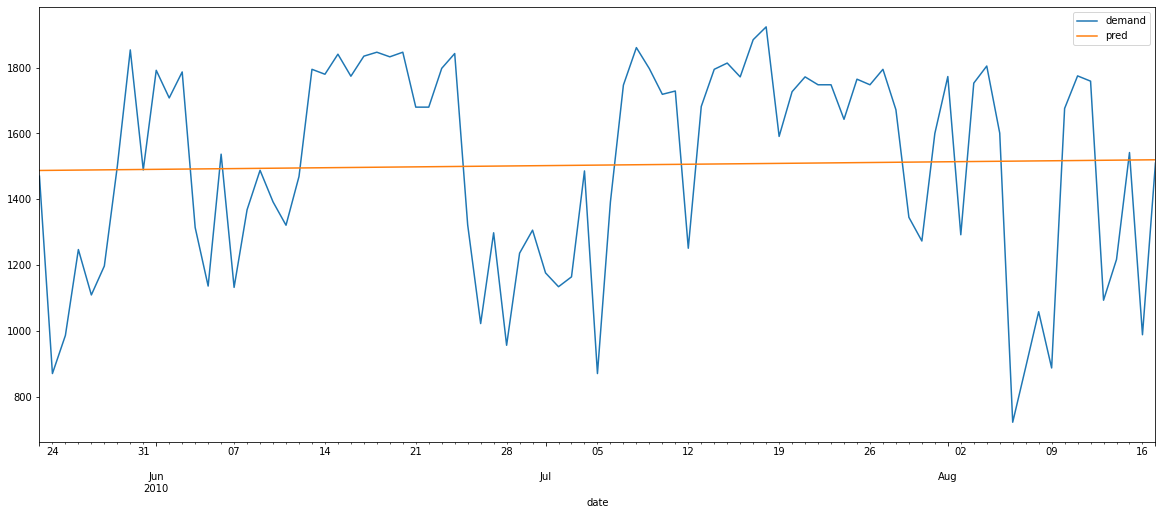

In [26]:
import numpy as np
lm=LinearRegression()

temp=df.copy()
temp.dropna(inplace=True)

x=np.arange(temp.shape[0]).reshape(-1,1)
y=temp.demand

lm.fit(x,y)

print(f'the slope of the genaralized trend is {lm.coef_}')

temp['pred']=lm.predict(x)

temp[['demand','pred']].plot(figsize=(20,8))

We can extend the idea of linear model to generate more representative features that can be incorporated/added inside ou linear model to develope a more robust generalised model that can help us explain this datset in a better way

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

class MLLinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def _check_feature_names(self):
        if not hasattr(self, 'featureNames_'):
            raise NotFittedError("FeatureNames not available yet")

        if len(self.featureNames_) == 0:
            raise ValueError("FeatureNames are empty")
    
    def get_feature_names(self):
        self._check_feature_names()
        return self.featureNames_


class window_composer(MLLinTransformer):
  def __init__(self,sampling_days,period_days):
    self.sampling_days=sampling_days
    self.period_days=period_days

  def transform(self,X,y=None):
    length_of_data=X.shape[0]
    num_of_samples=self.period_days//self.sampling_days

    temp=np.zeros(shape=(length_of_data,num_of_samples))
    characteristic_fn=np.ones(shape=self.sampling_days)#Currently simple characteristic function is used that is the box function; later decaying window functions can be introduced for interaction terms

    for i in range(temp.shape[1]):
      shift_characteristic_fn=np.zeros(shape=(self.period_days))
      shift_characteristic_fn[i*self.sampling_days:(i+1)*self.sampling_days]=characteristic_fn


      period_reps=length_of_data//self.period_days
      temp[:,i]=np.tile(shift_characteristic_fn,period_reps+1)[:length_of_data]
    
    self.temp_df=pd.DataFrame(temp,columns=[f'P_{self.period_days}_S_{i}' for i in range(temp.shape[1])])
    self.temp_df=pd.concat([pd.Series(np.arange(temp.shape[0]),name='trend')
                  ,self.temp_df],axis=1)

    return self.temp_df




In [34]:
from sklearn.pipeline import Pipeline
pip_1=Pipeline(
    steps=[('encode',window_composer(period_days=15,sampling_days=3)),
           ('reg',LinearRegression())
              ])

pip_1.fit(temp,y)

pip_1.named_steps['encode'].temp_df

,trend,P_15_S_0,P_15_S_1,P_15_S_2,P_15_S_3,P_15_S_4
0,0,1.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0
3,3,0.0,1.0,0.0,0.0,0.0
4,4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
82,82,0.0,0.0,1.0,0.0,0.0
83,83,0.0,0.0,1.0,0.0,0.0
84,84,0.0,0.0,0.0,1.0,0.0
85,85,0.0,0.0,0.0,1.0,0.0


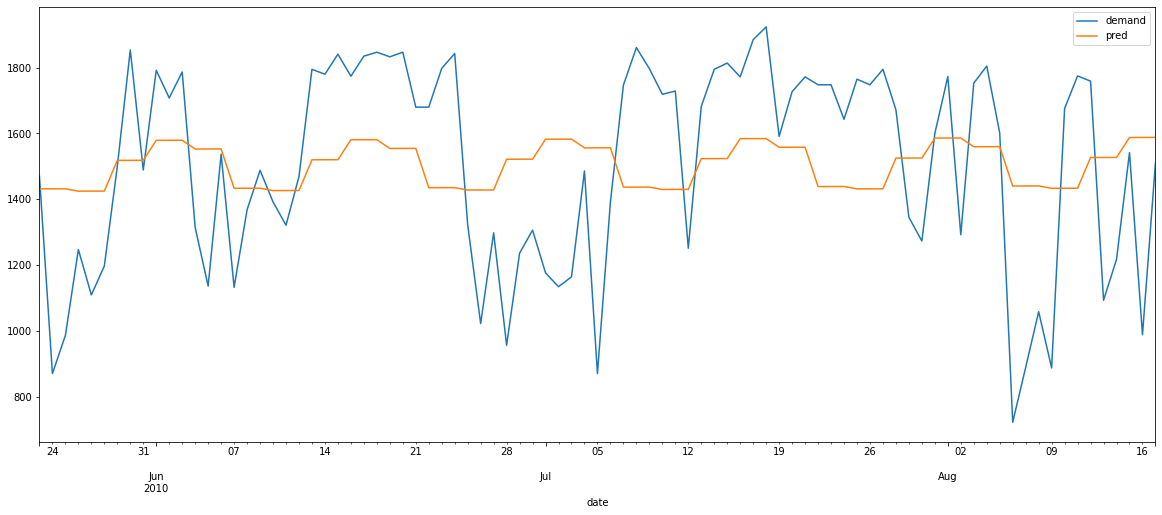

In [35]:
temp['pred']=pip_1.predict(temp)

temp[['demand','pred']].plot(figsize=(20,8))

# Elucidation of the transformer used above

At regular shift of periods we need to create spike detereministic function

Our baseline freq, for this data, is 1 day

Lets assume our period is 3 days and we need to sample it daily
sampling freq and period size both needs to be taken into consideration before formulating a periodic map
Ex 365 days period sampled at 30 days is diffrenet from 365 days period sampled at each/1 day

he shape of the function will change with increase in points within a sample we can generate a box or window funcyion for sample of 30 days 
However this is difficuly with sample of 1 day

In [ ]:
length_of_data=df.shape[0]
sampling_days=1#number of samples are 3 so we will have three new features triggering at regular interval of 3 samples
period_days=7

num_of_samples=period_days//sampling_days

temp=np.zeros(shape=(length_of_data,num_of_samples))

characteristic_fn=np.ones(shape=sampling_days)


for i in range(temp.shape[1]):
  shift_characteristic_fn=np.zeros(shape=(period_days))

  shift_characteristic_fn[i*sampling_days:(i+1)*sampling_days]=characteristic_fn

  period_reps=length_of_data//period_days
  temp[:,i]=np.tile(shift_characteristic_fn,period_reps+1)[:length_of_data]
  # break
  # =characteristic_fn #Majic of slicing can insert functions are regular interval here it is period_days
# np.arange(length_of_data)%3
temp[:20,:]
# plt.plot(temp)



In [15]:
#At regular shift of periods we need to create spike detereministic function

#Our baseline freq, for this data, is 1 day

#Lets assume our period is 3 days and we need to sample it daily
#sampling freq and period size both needs to be taken into consideration before formulating a periodic map
#Ex 365 days period sampled at 30 days is diffrenet from 365 days period sampled at each/1 day

#The shape of the function will change with increase in points within a sample we can generate a box or window funcyion for sample of 30 days 
#However this is difficuly with sample of 1 day

# length_of_data=df.shape[0]
# sampling_days=1#number of samples are 3 so we will have three new features triggering at regular interval of 3 samples
# period_days=3

# num_of_samples=period_days//sampling_days

# temp=np.zeros(shape=(length_of_data,num_of_samples))

# characteristic_fn=np.ones(shape=sampling_days)


# for i in range(temp.shape[1]):
#   temp[i::period_days,i]=characteristic_fn #Majic of slicing can insert functions are regular interval here it is period_days
# # np.arange(length_of_data)%3
# # temp


In [12]:
length_of_data=df.shape[0]
sampling_days=1#number of samples are 3 so we will have three new features triggering at regular interval of 3 samples
period_days=7

num_of_samples=period_days//sampling_days

temp=np.zeros(shape=(length_of_data,num_of_samples))

characteristic_fn=np.ones(shape=sampling_days)


for i in range(temp.shape[1]):
  shift_characteristic_fn=np.zeros(shape=(period_days))

  shift_characteristic_fn[i*sampling_days:(i+1)*sampling_days]=characteristic_fn

  period_reps=length_of_data//period_days
  temp[:,i]=np.tile(shift_characteristic_fn,period_reps+1)[:length_of_data]
  # break
  # =characteristic_fn #Majic of slicing can insert functions are regular interval here it is period_days
# np.arange(length_of_data)%3
temp[:20,:]
# plt.plot(temp)



array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]])

In [13]:
#If we had periodicty of 15 days and sampling freq of 3 days then we would have five repetitive functions repeated after 15 days

np.arange(30)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [14]:
# One period being explained using 5 samples
# Thus the entire dataset needs five more features 
# These features/or the behaviour of these features trigger at a period of 15 days and each feature is made up of three samples